In [1]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *

import matplotlib.pyplot as plt

from rdtools.soiling import soiling_srr
from src.features.build_features import *
from src.models.detect_soiling import *

# Prophet, my friend

In this notebook we briefly explore the results which can be obtained using Prophet and simple estimator of the soiling profile. Three approaches are investigated -- no soiling profile used; soiling profile used for normalisation; and soiling profile (the true one) is used as a regressor.

## Prophet without much tinkering

Simply take the log of the power signal and use Prophet with default settings

In [6]:
from fbprophet import Prophet

In [7]:
# Load a signal
df = import_df_from_zip_pkl('../data/raw/synthetic_soil.zip', index=32)
df = downsample_dataframe(df)

In [8]:
pdf = pd.DataFrame()
pdf['ds'] = df.index.tz_localize(None)
pdf['y'] = np.log(df.Power.to_numpy())
pdf.head()

,ds,y
0,2015-01-01,5.725408
1,2015-01-02,5.729874
2,2015-01-03,5.734731
3,2015-01-04,5.739940
4,2015-01-05,5.745480


In [9]:
m = Prophet( daily_seasonality=False, weekly_seasonality=False)
m.fit(pdf)

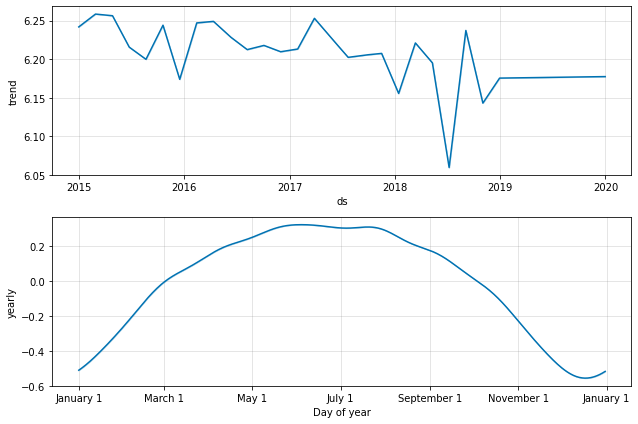

In [10]:
parts = m.predict(pdf[['ds']])
fig = m.plot_components(parts)

In [11]:
out = np.polyfit(np.arange(len(parts.trend)), parts.trend, 1)
line = np.arange(len(parts.trend)) * (np.exp(out[0]) - 1)  + 1

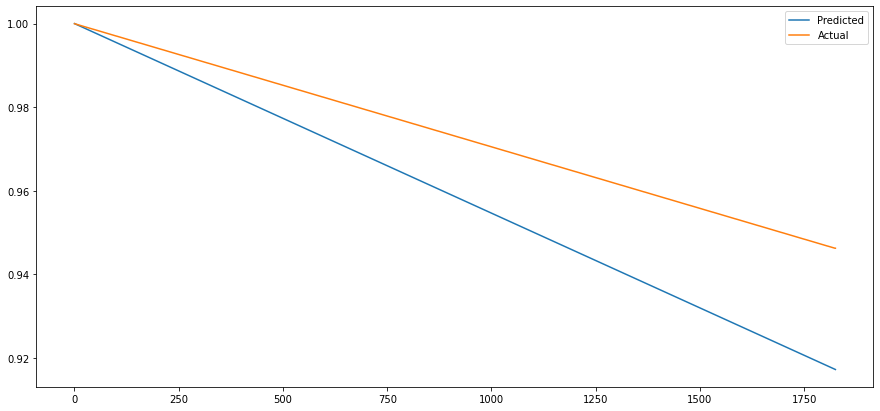

In [12]:
_, ax = plt.subplots(figsize=(15,7))
ax.plot(line, label="Predicted")
ax.plot(df.Degradation.to_numpy(), label="Actual")
ax.legend()

## Try with normalisation

Use the predicted soiling profile to normalise the power signal

In [13]:
df = import_df_from_zip_pkl('../data/raw/synthetic_soil.zip', index=32)
df = downsample_dataframe(df)

soiling_profile = fing_soiling_profile_with_rolling_avg(df)
normalised_power = (df[['Power']]/soiling_profile.to_numpy())

pdf_n = pd.DataFrame()
pdf_n['ds'] = df.index.tz_localize(None)
pdf_n['y'] = np.log(normalised_power.Power.to_numpy())
pdf_n.head()

/home/julius/Aug20_Epri/src/models/detect_soiling.py:56: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

/home/julius/Aug20_Epri/src/models/detect_soiling.py:57: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



,ds,y
0,2015-01-01,5.725408
1,2015-01-02,5.729874
2,2015-01-03,5.736503
3,2015-01-04,5.743486
4,2015-01-05,5.750804


In [14]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False)
m.fit(pdf_n)

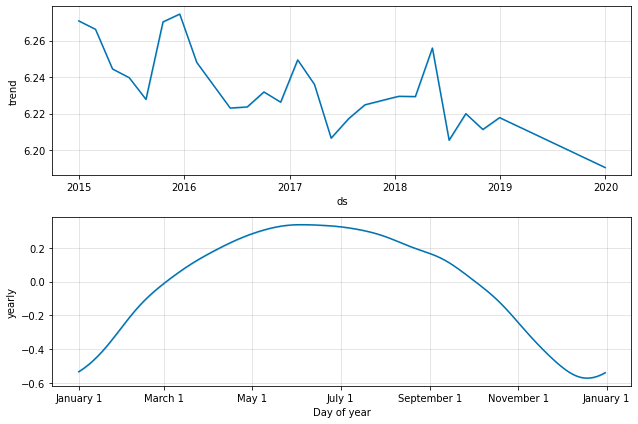

In [15]:
parts = m.predict(pdf_n[['ds']])
fig = m.plot_components(parts)

In [16]:
out = np.polyfit(np.arange(len(parts.trend)), parts.trend, 1)
line = np.arange(len(parts.trend)) * (np.exp(out[0]) - 1)  + 1

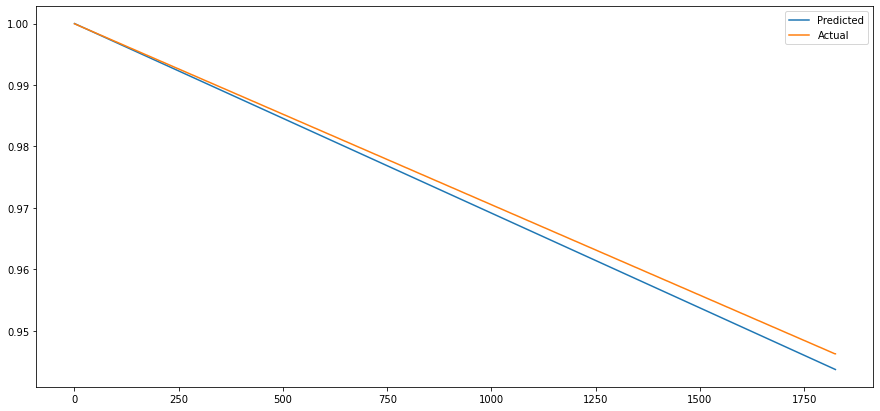

In [17]:
_, ax = plt.subplots(figsize=(15,7))
ax.plot(line, label="Predicted")
ax.plot(df.Degradation.to_numpy(), label="Actual")
ax.legend()

## Prophet with a regressor 

Finally, try using the actual soiling profile as a regressor

In [18]:
# Load a signal
df = import_df_from_zip_pkl('../data/raw/synthetic_soil.zip', index=32)
df = downsample_dataframe(df)

pdf_r = pd.DataFrame()
pdf_r['ds'] = df.index.tz_localize(None)
pdf_r['y'] = np.log(df.Power.to_numpy())
pdf_r.head()

,ds,y
0,2015-01-01,5.725408
1,2015-01-02,5.729874
2,2015-01-03,5.734731
3,2015-01-04,5.739940
4,2015-01-05,5.745480


In [19]:
pdf_r['soiling_profile'] = np.log(df.Soiling.to_numpy()) #compute_soiling_profile(df).soiling_factor.to_numpy()
pdf_r.head()

,ds,y,soiling_profile
0,2015-01-01,5.725408,-0.001201
1,2015-01-02,5.729874,-0.001792
2,2015-01-03,5.734731,-0.002393
3,2015-01-04,5.739940,-0.002994
4,2015-01-05,5.745480,-0.003596


In [20]:
m = Prophet( daily_seasonality=False, weekly_seasonality=False)
m.add_regressor('soiling_profile', prior_scale=2)
m.fit(pdf_r)

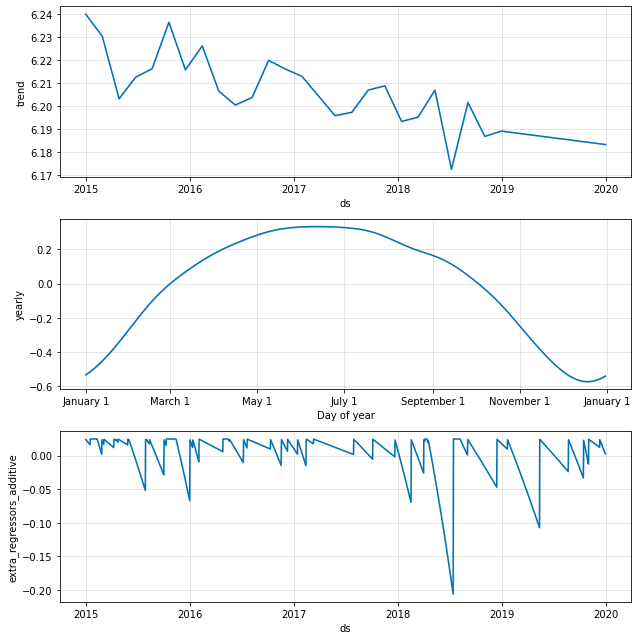

In [21]:
parts = m.predict(pdf_r[['ds', 'soiling_profile']])
fig = m.plot_components(parts)

In [22]:
out = np.polyfit(np.arange(len(parts.trend)), parts.trend, 1)
line = np.arange(len(parts.trend)) * (np.exp(out[0]) - 1)  + 1

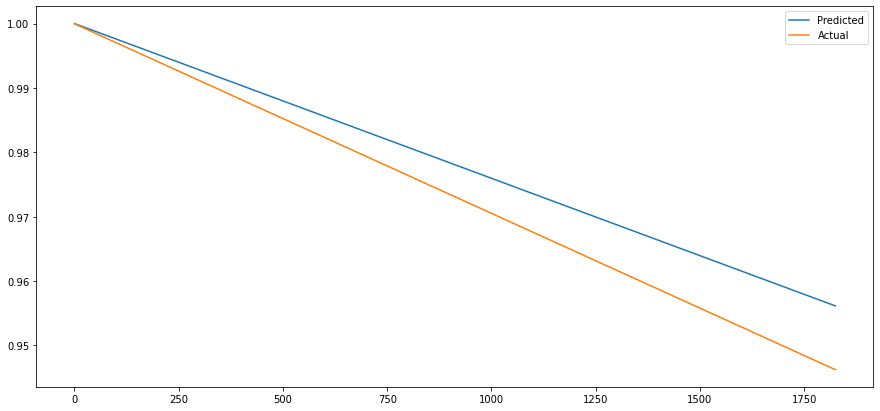

In [23]:
_, ax = plt.subplots(figsize=(15,7))
ax.plot(line, label="Predicted")
ax.plot(df.Degradation.to_numpy(), label="Actual")
ax.legend()

## Somehting to try

It might be worth to try using the cleaning events as the regressor rather than the soiling profile.